### Contents ###
The below information conveys strategies I used to build and evaluate a model to predict housing prices in Ames, Iowa as part of a Kaggle competition.

---
1. Data Cleaning
> a. Observe missing values <br>
> b. Dropping vs. Imputing <br>
> c. Deciding imputing technique

2. EDA, Feature Engineering & Selection
> a. Scatter plots <br>
> b. Correlations to determine importance of features <br>
> c. Fine tuning selected features using Lasso
> d. Outlier analysis
> e. Preprocessing (scaling data, train/test splits, transforming data)

3. Modeling, Evaluation, Comparisons
> a. Building models <br>
> b. Evaluating r2 scores <br>
> c. Evaluating RMSE <br>

4. Conclusion <br>
---
The remainder of the notebook contains my code, visualizations, and analysis of the housing dataset as I attempt to build a predictive model that focuses on minimizing root mean squared error (RMSE).

### Part I: Imports, Reading Data, Basic Info

In [1]:
# imports! 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# more imports!
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression # model for linear reg 
from sklearn.linear_model import LassoCV, RidgeCV # model for lasso & ridge
from sklearn.metrics import mean_squared_error # metrics for evaluation
from sklearn.preprocessing import StandardScaler, OneHotEncoder # for scaling data & encoding
from sklearn.compose import ColumnTransformer

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
# reading training and test data
df_train = pd.read_csv('./starter_datasets/train.csv')
df_test = pd.read_csv('./starter_datasets/test.csv')

# goal: clean both datasets together, keep 'test' set away from 'train' to prevent data leakage, don't learn anything from test set

In [3]:
# dimensions of train, test
print(f"Original Train: {df_train.shape}")
print(f"Original Test: {df_test.shape}")

# as expected, test is 1 column shy (saleprice outcome)
# also, it appears train/test have roughly been split 70/30
print("Data has been split roughly 70/30, train/test")

Original Train: (2051, 81)
Original Test: (878, 80)
Data has been split roughly 70/30, train/test


---

### Part II: Data Cleaning

First, let's observe what data we have: Numerical vs. Categorical.

In [4]:
df_train.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [5]:
numerical = list(df_train.select_dtypes(exclude = 'object').columns)
categorical = list(df_train.select_dtypes(include = 'object').columns)

# test
numerical_test = list(df_test.select_dtypes(exclude = 'object').columns)
categorical_test = list(df_test.select_dtypes(include = 'object').columns)

#### All Categorical Variables: 
['MS Zoning',
 'Street',
 'Alley',
 'Lot Shape',
 'Land Contour',
 'Utilities',
 'Lot Config',
 'Land Slope',
 'Neighborhood',
 'Condition 1',
 'Condition 2',
 'Bldg Type',
 'House Style',
 'Roof Style',
 'Roof Matl',
 'Exterior 1st',
 'Exterior 2nd',
 'Mas Vnr Type',
 'Exter Qual',
 'Exter Cond',
 'Foundation',
 'Bsmt Qual',
 'Bsmt Cond',
 'Bsmt Exposure',
 'BsmtFin Type 1',
 'BsmtFin Type 2',
 'Heating',
 'Heating QC',
 'Central Air',
 'Electrical',
 'Kitchen Qual',
 'Functional',
 'Fireplace Qu',
 'Garage Type',
 'Garage Finish',
 'Garage Qual',
 'Garage Cond',
 'Paved Drive',
 'Pool QC',
 'Fence',
 'Misc Feature',
 'Sale Type']

I used: **df_train[categorical].iloc[:5, start : stop]** to go through the columns and verify these should be categorical. They check out.

---

#### All Numerical Variables: 
['Id',
 'PID',
 'MS SubClass',
 'Lot Frontage',
 'Lot Area',
 'Overall Qual',
 'Overall Cond',
 'Year Built',
 'Year Remod/Add',
 'Mas Vnr Area',
 'BsmtFin SF 1',
 'BsmtFin SF 2',
 'Bsmt Unf SF',
 'Total Bsmt SF',
 '1st Flr SF',
 '2nd Flr SF',
 'Low Qual Fin SF',
 'Gr Liv Area',
 'Bsmt Full Bath',
 'Bsmt Half Bath',
 'Full Bath',
 'Half Bath',
 'Bedroom AbvGr',
 'Kitchen AbvGr',
 'TotRms AbvGrd',
 'Fireplaces',
 'Garage Yr Blt',
 'Garage Cars',
 'Garage Area',
 'Wood Deck SF',
 'Open Porch SF',
 'Enclosed Porch',
 '3Ssn Porch',
 'Screen Porch',
 'Pool Area',
 'Misc Val',
 'Mo Sold',
 'Yr Sold',
 'SalePrice']
 
 

Again, I used: **df_train[numerical].iloc[:5, start : stop]** to go through the columns and verify if these should be numerical. Notes below!

***Don't make sense as numerical*** <br>
['Id', 'PID', ]

***Change to int (don't make sense as float)*** <br>
However, these have NaN values, so I will impute the missing values first before converting both to integer. (Later) <br>
['Garage Yr Blt', 'Garage Cars']

In [6]:
# Let's convert Id & PID to 'object' type

# First, check if there are any np.nan values in 'Id'
print(f"Np.nan in 'Id': {np.nan in df_train['Id'].value_counts().index}")
print(f"Np.nan in 'PID': {np.nan in df_train['PID'].value_counts().index}")

Np.nan in 'Id': False
Np.nan in 'PID': False


In [7]:
# Great, now I can convert both
df_train['Id'] = df_train['Id'].astype(object)
df_train['PID'] = df_train['PID'].astype(object)

df_test['Id'] = df_test['Id'].astype(object)
df_test['PID'] = df_test['PID'].astype(object)

# Now, recall Numerical & Categorical lists to update them
numerical_test = list(df_test.select_dtypes(exclude = 'object').columns)    # ID, PID removed
categorical_test = list(df_test.select_dtypes(include = 'object').columns)    # ID, PID added

---
#### Dealing with Missing Values
Here, I want to decide which variables have missing values and how many. If a ton of values are missing, it makes sense to drop the variable altogether. If there aren't too many missing values, it makes sense to impute the values so we can include them in our model (if necessary).

In [8]:
# hard to view which columns have how many missing values
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               2051 non-null   object 
 1   PID              2051 non-null   object 
 2   MS SubClass      2051 non-null   int64  
 3   MS Zoning        2051 non-null   object 
 4   Lot Frontage     1721 non-null   float64
 5   Lot Area         2051 non-null   int64  
 6   Street           2051 non-null   object 
 7   Alley            140 non-null    object 
 8   Lot Shape        2051 non-null   object 
 9   Land Contour     2051 non-null   object 
 10  Utilities        2051 non-null   object 
 11  Lot Config       2051 non-null   object 
 12  Land Slope       2051 non-null   object 
 13  Neighborhood     2051 non-null   object 
 14  Condition 1      2051 non-null   object 
 15  Condition 2      2051 non-null   object 
 16  Bldg Type        2051 non-null   object 
 17  House Style   

In [9]:
df_train.isnull().sum()

Id                0
PID               0
MS SubClass       0
MS Zoning         0
Lot Frontage    330
               ... 
Misc Val          0
Mo Sold           0
Yr Sold           0
Sale Type         0
SalePrice         0
Length: 81, dtype: int64

In [10]:
# making a missing values DF
train_missing_vals = pd.DataFrame(df_train.isnull().mean(), columns = ['Avg. Missing']).sort_values(by = 'Avg. Missing', ascending = False)
train_missing_vals['Total Missing'] = df_train.isnull().sum()

test_missing_vals = pd.DataFrame(df_test.isnull().mean(), columns = ['Avg. Missing']).sort_values(by = 'Avg. Missing', ascending = False)
test_missing_vals['Total Missing'] = df_test.isnull().sum()

# let's see which have missing values at all --> 26 total vars have missing values > 0
train_missing_vals[train_missing_vals['Avg. Missing'] > 0]

,Avg. Missing,Total Missing
Pool QC,0.995612,2042
Misc Feature,0.968308,1986
Alley,0.931741,1911
Fence,0.804973,1651
Fireplace Qu,0.487567,1000
Lot Frontage,0.160897,330
Garage Finish,0.055583,114
Garage Qual,0.055583,114
Garage Yr Blt,0.055583,114
Garage Cond,0.055583,114


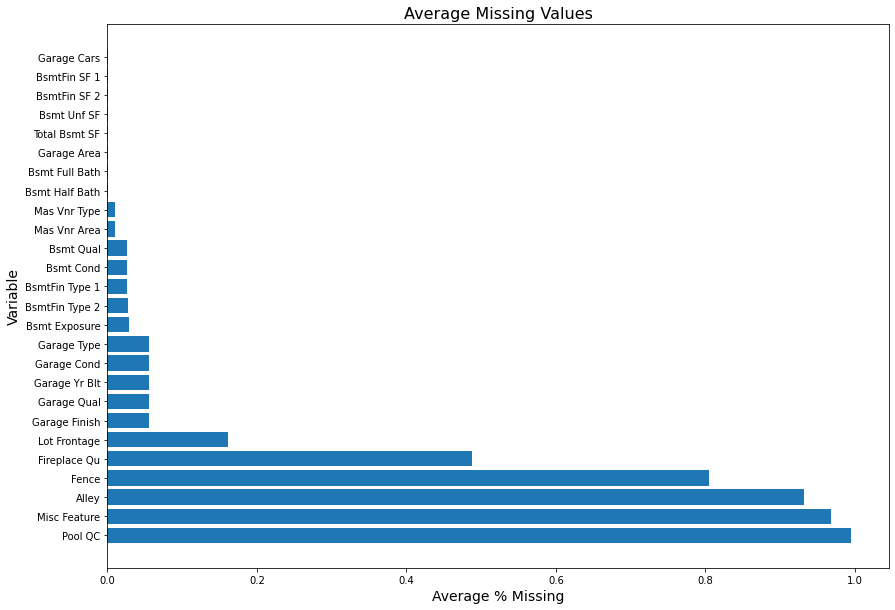

In [11]:
# graphing the number of missing values
plt.figure(figsize = (14,10))
plt.barh(y = train_missing_vals[train_missing_vals['Avg. Missing'] > 0].index, width = train_missing_vals[train_missing_vals['Avg. Missing'] > 0]['Avg. Missing'])
plt.title('Average Missing Values', size = 16)
plt.ylabel('Variable', size = 14)
plt.xlabel('Average % Missing', size = 14);

# saving
plt.savefig('./project2_graphs/missing_vals.jpeg')

Based on the chart, it makes sense to drop: **['Fireplace Qu', 'Fence', 'Alley', 'Misc Feature', 'Pool QC'].** <br>
For the rest, we can impute missing values using mean, median, or mode.

In [12]:
#### MAJOR ALTERATION OF KEY DATAFRAME ####

# Dropping ['Fireplace Qu', 'Fence', 'Alley', 'Misc Feature', 'Pool QC'] from df_train

df_train.drop(columns = ['Fireplace Qu', 'Fence', 'Alley', 'Misc Feature', 'Pool QC'], inplace = True)

df_test.drop(columns = ['Fireplace Qu', 'Fence', 'Alley', 'Misc Feature', 'Pool QC'], inplace = True)

In [13]:
# Verifying: 5 fewer columns
df_train.shape, df_test.shape

((2051, 76), (878, 75))

In [14]:
# let's add another column to represent the type of variable
train_missing_vals['Var Type'] = ['numerical' if i in numerical else 'categorical' for i in train_missing_vals.index ]

test_missing_vals['Var Type'] = ['numerical' if i in numerical_test else 'categorical' for i in test_missing_vals.index ]


# these are the variables we need to do some imputations for
impute_vars = train_missing_vals[(train_missing_vals['Avg. Missing'] > 0) & (train_missing_vals['Avg. Missing'] < 0.4)]

impute_vars_test = test_missing_vals[(test_missing_vals['Avg. Missing'] > 0) & (test_missing_vals['Avg. Missing'] < 0.4)]

In [15]:
impute_vars

,Avg. Missing,Total Missing,Var Type
Lot Frontage,0.160897,330,numerical
Garage Finish,0.055583,114,categorical
Garage Qual,0.055583,114,categorical
Garage Yr Blt,0.055583,114,numerical
Garage Cond,0.055583,114,categorical
Garage Type,0.055095,113,categorical
Bsmt Exposure,0.028279,58,categorical
BsmtFin Type 2,0.027304,56,categorical
BsmtFin Type 1,0.026816,55,categorical
Bsmt Cond,0.026816,55,categorical


#### Imputing Categorical Variables
For the categorical ones, I'll use the **mode** to fill in the missing values. First, I'll test it on one (with inplace = False). After confirming my code works, I will write a loop to go through **all** categorical vars in ***impute_vars*** dataframe.

In [16]:
# This whole cell is just me testing the imputation using mode for 'Garage Finish' (a categorical var)
print(f"Before Impute: {df_train['Garage Finish'].value_counts()[0]}")
print(f"After Impute: {df_train['Garage Finish'].fillna(value = df_train['Garage Finish'].mode()[0]).value_counts()[0]}")

print("The count for 'Unf' went up by 114. There were 114 missing values for this variable, so this implies that our imputation using mode works. Noice. 😎")

Before Impute: 849
After Impute: 963
The count for 'Unf' went up by 114. There were 114 missing values for this variable, so this implies that our imputation using mode works. Noice. 😎


In [17]:
# Now, let's apply the above to ALL categorical variables that need imputing using the 'for' loop I wrote below:

for i, val in impute_vars['Var Type'].iteritems():    # Shoutout ChatGPT for .iteritems()
    if val == 'categorical':
        df_train[i].fillna(value = df_train[i].mode()[0], inplace = True)
        df_test[i].fillna(value = df_train[i].mode()[0], inplace = True)
        
        
# # now testing      --> DATA LEAKAGE --> DON'T DO THIS (saving for reference)   
# for i, val in impute_vars_test['Var Type'].iteritems():    # Shoutout ChatGPT for .iteritems()
#     if val == 'categorical':
#         df_test[i].fillna(value = df_test[i].mode()[0], inplace = True)

<ipython-input-17-dd970deb0ac7>:3: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for i, val in impute_vars['Var Type'].iteritems():    # Shoutout ChatGPT for .iteritems()


In [18]:
# Testing!
df_train['Garage Qual'].isna().sum(), df_test['Garage Qual'].isna().sum()    # missing values taken care of   # missing values taken care of

(0, 0)

#### Imputing Numerical Variables
This will be more tricky, since I want to first decide whether to use the mean or median. From my stats classes, I remember that typically a variable is about normal if the mean is equal to the median and mode. <br> 
To determine whether to use mean or median, I will calculate the **skewness** for each numerical value. <br>
Per "https://community.gooddata.com/metrics-and-maql-kb-articles-43/normality-testing-skewness-and-kurtosis-241", skewness > 1 or < -1 indicates high level of skew, which could imply presence of outliers.
> 1. If skewness for the variable > 1 or < -1, I will impute with the median.
> 2. Otherwise, I'll use the mean.

In [19]:
# testing on 'Lot Frontage' variable w/out 'inplace = True'
df_train['Lot Frontage'].fillna(value = df_train['Lot Frontage'].mean()).isna().sum()

0

In [20]:
# Like before, let's apply the .fillna() to all numerical vars

for i, val in impute_vars['Var Type'].iteritems():
    if val == 'numerical':
        if abs(df_train[i].skew()) > 1: # highly skewed, impute w/ median
            df_train[i].fillna(value = df_train[i].median(), inplace = True)   
            df_test[i].fillna(value = df_train[i].median(), inplace = True)     

        else: # impute w/ mean
            df_train[i].fillna(value = df_train[i].mean(), inplace = True)
            df_test[i].fillna(value = df_train[i].mean(), inplace = True)
            
            
# # test --> DONT DO THIS (saving for reference)
# for i, val in impute_vars_test['Var Type'].iteritems():
#     if val == 'numerical':
#         if abs(df_test[i].skew()) > 1: # highly skewed, impute w/ median
#             df_test[i].fillna(value = df_test[i].median(), inplace = True)     
#         else: # impute w/ mean
#             df_test[i].fillna(value = df_test[i].mean(), inplace = True)

<ipython-input-20-7be8444fdac3>:3: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for i, val in impute_vars['Var Type'].iteritems():


In [21]:
# Testing!
df_train.isna().sum().max(), df_test.isna().sum().max() # no more missing vals

(0, 1)

In [22]:
# Lastly, I'll also drop ID & PID since these won't be necessary for my regressions
df_train.drop(columns = ['Id', 'PID'], inplace = True)

df_test.drop(columns = ['Id', 'PID'], inplace = True)

---

### Part III: Feature Processing & Engineering

In [23]:
df_train.head()

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,...,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,60,RL,68.0,13517,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,...,44,0,0,0,0,0,3,2010,WD,130500
1,60,RL,43.0,11492,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,...,74,0,0,0,0,0,4,2009,WD,220000
2,20,RL,68.0,7922,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,52,0,0,0,0,0,1,2010,WD,109000
3,60,RL,73.0,9802,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,0,4,2010,WD,174000
4,50,RL,82.0,14235,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,59,0,0,0,0,0,3,2010,WD,138500


In [24]:
# Since several changes have been made, I'll recall which variables are numerical vs. categorical
numerical = list(df_train.select_dtypes(exclude = 'object').columns)
categorical = list(df_train.select_dtypes(include = 'object').columns)

numerical_test = list(df_test.select_dtypes(exclude = 'object').columns)
categorical_test = list(df_test.select_dtypes(include = 'object').columns)

Before continuing, I will process some of the numerical columns first, and then move to the categorical columns.

#### Numerical

In [25]:
df_train[numerical].iloc[:5,:10]

,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2
0,60,68.0,13517,6,8,1976,2005,289.0,533.0,0.0
1,60,43.0,11492,7,5,1996,1997,132.0,637.0,0.0
2,20,68.0,7922,5,7,1953,2007,0.0,731.0,0.0
3,60,73.0,9802,5,5,2006,2007,0.0,0.0,0.0
4,50,82.0,14235,6,8,1900,1993,0.0,0.0,0.0


In [26]:
# MS SubClass should be an 'object' instead
df_train['MS SubClass'].astype(object)

df_test['MS SubClass'].astype(object)

0      190
1       90
2       60
3       30
4       20
      ... 
873     60
874     60
875     20
876     20
877     20
Name: MS SubClass, Length: 878, dtype: object

In [27]:
# making 'age' variables using year columns --> dataset collected in 2011, using 2011 as base
df_train['age'] = 2011 - df_train['Year Built']
df_train['sold_age'] = 2011 - df_train['Yr Sold']
df_train['remodel_age'] = 2011 - df_train['Year Remod/Add']
df_train['garage_age'] = 2011 - df_train['Garage Yr Blt']


# test
df_test['age'] = 2011 - df_test['Year Built']
df_test['sold_age'] = 2011 - df_test['Yr Sold']
df_test['remodel_age'] = 2011 - df_test['Year Remod/Add']
df_test['garage_age'] = 2011 - df_test['Garage Yr Blt']

In [28]:
# now, dropping the year columns
df_train.drop(columns = ['Year Built'], inplace = True)
df_train.drop(columns = ['Yr Sold'], inplace = True)
df_train.drop(columns = ['Year Remod/Add'], inplace = True)
df_train.drop(columns = ['Garage Yr Blt'], inplace = True)


# test
df_test.drop(columns = ['Year Built'], inplace = True)
df_test.drop(columns = ['Yr Sold'], inplace = True)
df_test.drop(columns = ['Year Remod/Add'], inplace = True)
df_test.drop(columns = ['Garage Yr Blt'], inplace = True)

In [29]:
# redefining numerical
numerical = list(df_train.select_dtypes(exclude = 'object').columns)

numerical_test = list(df_test.select_dtypes(exclude = 'object').columns)

In [30]:
df_train[numerical].iloc[:5, 30:]

,Misc Val,Mo Sold,SalePrice,age,sold_age,remodel_age,garage_age
0,0,3,130500,35,1,6,35.0
1,0,4,220000,15,2,14,14.0
2,0,1,109000,58,1,4,58.0
3,0,4,174000,5,1,4,4.0
4,0,3,138500,111,1,18,54.0


In [31]:
# Creating Binary Variables for certain home features
# 1 = yes, 0 = no

# Basement? 
df_train['basement_binary'] = [1 if i > 0 else 0 for i in df_train['Total Bsmt SF'].values]
df_test['basement_binary'] = [1 if i > 0 else 0 for i in df_test['Total Bsmt SF'].values]


# Fireplace?
df_train['fireplace_binary'] = [1 if i > 0 else 0 for i in df_train['Fireplaces'].values]
df_test['fireplace_binary'] = [1 if i > 0 else 0 for i in df_test['Fireplaces'].values]


# Garage?
df_train['garage_binary'] = [1 if i > 0 else 0 for i in df_train['Garage Area'].values]
df_test['garage_binary'] = [1 if i > 0 else 0 for i in df_test['Garage Area'].values]


# Wood Deck?
df_train['wooddeck_binary'] = [1 if i > 0 else 0 for i in df_train['Wood Deck SF'].values]
df_test['wooddeck_binary'] = [1 if i > 0 else 0 for i in df_test['Wood Deck SF'].values]


# TOTAL PORCH SQ_FT
df_train['total_porch_sqft'] = df_train['Open Porch SF'] + df_train['Enclosed Porch'] + df_train['3Ssn Porch'] + df_train['Screen Porch']
df_test['total_porch_sqft'] = df_test['Open Porch SF'] + df_test['Enclosed Porch'] + df_test['3Ssn Porch'] + df_test['Screen Porch']


# Has porch? (any porch at all?)
df_train['porch_binary'] = [1 if i > 0 else 0 for i in df_train['total_porch_sqft'].values]
df_test['porch_binary'] = [1 if i > 0 else 0 for i in df_test['total_porch_sqft'].values]


# Pool?
df_train['pool_binary'] = [1 if i > 0 else 0 for i in df_train['Pool Area'].values]
df_test['pool_binary'] = [1 if i > 0 else 0 for i in df_test['Pool Area'].values]

I made the above 7 variables to get a better sense of whether these features are actually present in the home or not, instead of representing every bit by numbers or square footage.

In [32]:
# redefining numerical
numerical = list(df_train.select_dtypes(exclude = 'object').columns)
numerical_test = list(df_test.select_dtypes(exclude = 'object').columns)

#### Categorical

In [33]:
# go through the columns and observe (alter col index)
df_train[categorical].iloc[:5, 30:]

,Functional,Garage Type,Garage Finish,Garage Qual,Garage Cond,Paved Drive,Sale Type
0,Typ,Attchd,RFn,TA,TA,Y,WD
1,Typ,Attchd,RFn,TA,TA,Y,WD
2,Typ,Detchd,Unf,TA,TA,Y,WD
3,Typ,BuiltIn,Fin,TA,TA,Y,WD
4,Typ,Detchd,Unf,TA,TA,N,WD


In [34]:
# binarize Central Air to 1 or 0 --> indicate whether house has central air
df_train['Central Air'].replace({'Y': 1, 'N': 0}, inplace = True)

df_test['Central Air'].replace({'Y': 1, 'N': 0}, inplace = True)

In [35]:
# binarize Paved Drive to 1 or 0
df_train['Paved Drive'].replace({'Y' : 1, 'P' : 1, 'N' : 0}, inplace = True)

df_test['Paved Drive'].replace({'Y' : 1, 'P' : 1, 'N' : 0}, inplace = True)

In [36]:
# renaming
df_train.rename(columns = {'Central Air' : 'air_binary', 'Paved Drive' : 'paved_binary'}, inplace = True)

df_test.rename(columns = {'Central Air' : 'air_binary', 'Paved Drive' : 'paved_binary'}, inplace = True)

In [37]:
# redefining categorical
categorical = list(df_train.select_dtypes(include = 'object').columns)

categorical_test = list(df_test.select_dtypes(include = 'object').columns)

Binarizing the couple variables above would have made 2 new numerical vars. I will now redefine categorical, just to keep the list updated (like I did with numerical).

In [38]:
# new df_train/test dimensions
df_train.shape, df_test.shape

((2051, 81), (878, 80))

### OneHotEncoding & Transforming
Now, we need to use OneHotEncoder to make dummies and ensure that they will be present in both df_train **and** df_test. <br>
Note: We will only use this on our categorical columns using 'categorical' and 'categorical_test' lists we made above.

In [39]:
# instantiate ohe
ohe = OneHotEncoder(drop = 'first', 
                   handle_unknown = 'ignore',
                   sparse_output = False)

In [40]:
# now instantiate ColumnTransformer (this will allow us to CHOOSE which columns to dummify using our categorical lists)
ctx = ColumnTransformer(
    transformers = [ # list of tuples
        #('alias first', instandiated_transformer, list_of_cols_to_apply)
        ('one_hot', ohe, categorical) # categorical list we defined
    ], remainder = 'passthrough', # don't drop other features
    verbose_feature_names_out = False
)

In [41]:
# fit to WHOLE training set
ctx.fit(df_train.drop(columns = ['SalePrice']))

ColumnTransformer(remainder='passthrough',
                  transformers=[('one_hot',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore',
                                               sparse_output=False),
                                 ['MS Zoning', 'Street', 'Lot Shape',
                                  'Land Contour', 'Utilities', 'Lot Config',
                                  'Land Slope', 'Neighborhood', 'Condition 1',
                                  'Condition 2', 'Bldg Type', 'House Style',
                                  'Roof Style', 'Roof Matl', 'Exterior 1st',
                                  'Exterior 2nd', 'Mas Vnr Type', 'Exter Qual',
                                  'Exter Cond', 'Foundation', 'Bsmt Qual',
                                  'Bsmt Cond', 'Bsmt Exposure',
                                  'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating',
                                  'Heating QC', 'Electrical', 'Kitchen Qual',
                                  'Functional', ...])],
                  verbose_feature_names_out=False)

In [42]:
# now that the fitting is done, we can actually transform our df_train & df_test

# transform train
df_train_2 = ctx.transform(df_train)

#transform test
df_test_2 = ctx.transform(df_test)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [13, 14, 15, 16, 25, 27, 28, 34] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [43]:
# Great, now we can recreate these into dataframes
df_train_2 = pd.DataFrame(df_train_2,
                          columns = ctx.get_feature_names_out())

df_test_2 = pd.DataFrame(df_test_2,
                         columns = ctx.get_feature_names_out())

In [44]:
# add back on 'SalePrice' to our new encoded TRAINING dataframe
df_train_2['SalePrice'] = df_train['SalePrice']

In [45]:
# let's confirm, what's missing in test?
for col in list(df_train_2.columns):
    if col not in df_test_2:
        print(f"This is exactly what we expect to see: '{col}'")

This is exactly what we expect to see: 'SalePrice'


In [46]:
# verifying the shape of both dataframes
print(f"Encoded Training CSV DF: {df_train_2.shape}")
print(f"Encoded Testing CSV DF: {df_test_2.shape}")

Encoded Training CSV DF: (2051, 239)
Encoded Testing CSV DF: (878, 238)


Great, now we have a ton of variables/features to work with. I will now move on to EDA to mostly perform correlation analysis and choose the best features.

---

### Part IV: Quick EDA & Feature Selection Set 1

**sqrt(2051) = ~ 45, goal is to stay under 45 features**

In [47]:
corrs = pd.DataFrame(df_train_2.corr()['SalePrice']).sort_values(by = 'SalePrice', ascending = False)

In [48]:
# let's choose our first features by filtering abs(correlation) > 0.5
corrs[(abs(corrs['SalePrice']) > 0.5) & (corrs.index != 'SalePrice')]

,SalePrice
Overall Qual,0.800207
Gr Liv Area,0.697038
Garage Area,0.650246
Garage Cars,0.648197
Total Bsmt SF,0.628754
1st Flr SF,0.618486
Full Bath,0.537969
Foundation_PConc,0.529047
TotRms AbvGrd,0.504014
Mas Vnr Area,0.503579


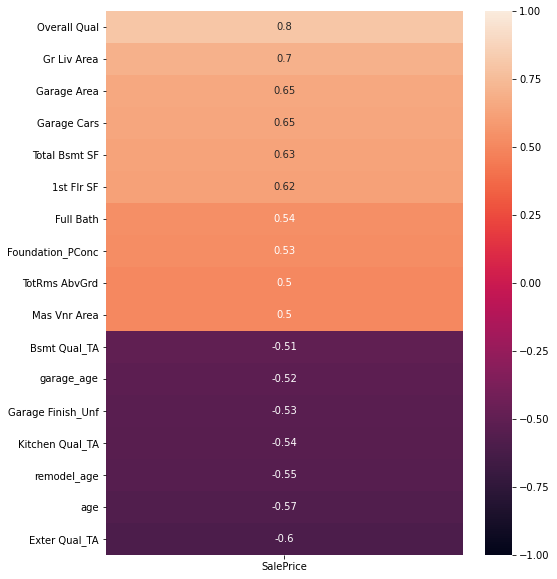

In [49]:
# let's plot a heatmap of correlations and visually see any that are abs() > 0.5
plt.figure(figsize = (8, 10))
sns.heatmap(corrs[(abs(corrs['SalePrice']) > 0.5) & (corrs.index != 'SalePrice')], vmin = -1, vmax = 1, annot = True);

In [50]:
# storing feature set 1 into a list
features_1 = list(corrs[(abs(corrs['SalePrice']) > 0.5) & (corrs.index != 'SalePrice')].index)

In [51]:
# However, this feature set contains dummy variables, some of which are missing their complementary dummies
# So, let's add them in as features
features_1

['Overall Qual',
 'Gr Liv Area',
 'Garage Area',
 'Garage Cars',
 'Total Bsmt SF',
 '1st Flr SF',
 'Full Bath',
 'Foundation_PConc',
 'TotRms AbvGrd',
 'Mas Vnr Area',
 'Bsmt Qual_TA',
 'garage_age',
 'Garage Finish_Unf',
 'Kitchen Qual_TA',
 'remodel_age',
 'age',
 'Exter Qual_TA']

In [52]:
for i in list(df_train_2.columns): 
    if 'Foundation_' in i:
        features_1.append(i)
    elif 'Bsmt Qual_' in i:
        features_1.append(i)
    elif 'Garage Finish_' in i:
        features_1.append(i)
    elif 'Kitchen Qual_' in i:
        features_1.append(i)
    elif 'Exter Qual_' in i:
        features_1.append(i)
    else:
        pass

In [53]:
# great, now we have a more full feature set #1
features_1

['Overall Qual',
 'Gr Liv Area',
 'Garage Area',
 'Garage Cars',
 'Total Bsmt SF',
 '1st Flr SF',
 'Full Bath',
 'Foundation_PConc',
 'TotRms AbvGrd',
 'Mas Vnr Area',
 'Bsmt Qual_TA',
 'garage_age',
 'Garage Finish_Unf',
 'Kitchen Qual_TA',
 'remodel_age',
 'age',
 'Exter Qual_TA',
 'Exter Qual_Fa',
 'Exter Qual_Gd',
 'Exter Qual_TA',
 'Foundation_CBlock',
 'Foundation_PConc',
 'Foundation_Slab',
 'Foundation_Stone',
 'Foundation_Wood',
 'Bsmt Qual_Fa',
 'Bsmt Qual_Gd',
 'Bsmt Qual_Po',
 'Bsmt Qual_TA',
 'Kitchen Qual_Fa',
 'Kitchen Qual_Gd',
 'Kitchen Qual_TA',
 'Garage Finish_RFn',
 'Garage Finish_Unf']

### Part V: Modeling & Evaluation

#### Feature Set #1

In [54]:
# Let's make X & y for this first round of performance testing
X_set1 = df_train_2[features_1]
y_set1 = df_train_2['SalePrice']

In [55]:
# train/test splits
X_set1_train, X_set1_test, y_set1_train, y_set1_test = train_test_split(X_set1, y_set1, test_size = 0.2, random_state = 42) # random_state for replicability

In [56]:
# Scaling the data
sc = StandardScaler()

# fit_transform the X_set1_train
Z_set1_train = sc.fit_transform(X_set1_train)

# just transform X_set1_test
Z_set1_test = sc.transform(X_set1_test)

#### 1. Model 1 - MLR

In [57]:
# instantiate model
model1_lr = LinearRegression()

# fit the model on transformed TRAIN data
model1_lr.fit(Z_set1_train, y_set1_train)

LinearRegression()

In [58]:
print(f"LinearRegression - Training Score: {round(model1_lr.score(Z_set1_train, y_set1_train), 4)}")
print(f"LinearRegression - Test Score: {round(model1_lr.score(Z_set1_test, y_set1_test), 4)}")

LinearRegression - Training Score: 0.827
LinearRegression - Test Score: 0.8739


These R2 scores seem encouraging, though I am a bit skeptical that the model performed better on the test set that it did on the training set. <br>
However, the model may have some merit for predictive purposes.

In [59]:
# Now, let's predict y's using the testing set and observe the RMSE
y_set1_preds = model1_lr.predict(Z_set1_test)

In [60]:
# RMSE
mean_squared_error(y_set1_test, y_set1_preds, squared = False )

27374.585430043346

In [61]:
# storing evaluation metrics for this model
model1_lr_scores = {"Name": "MLR Model 1","Training": round(model1_lr.score(Z_set1_train, y_set1_train), 4),
                   "Test": round(model1_lr.score(Z_set1_test, y_set1_test), 4),
                   "RMSE": round(mean_squared_error(y_set1_test, y_set1_preds, squared = False ), 2)} 

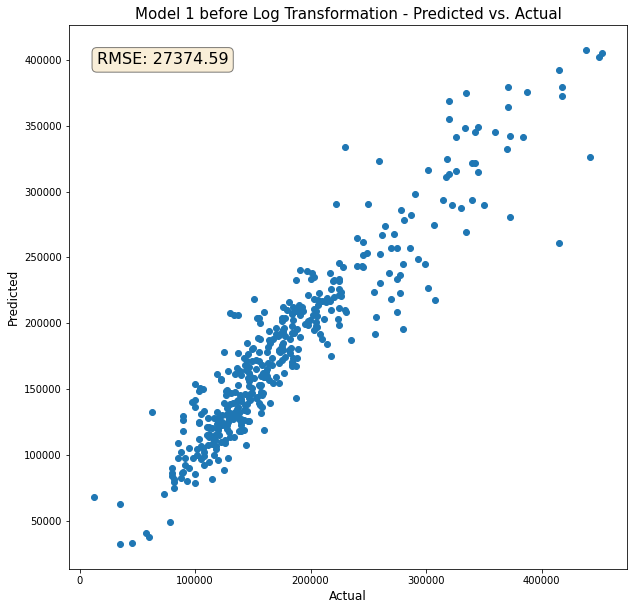

In [62]:
# Plotting Model 1 - Pred vs. Actual
plt.figure(figsize = (10,10))
plt.scatter(x = y_set1_test, y = y_set1_preds)
plt.title("Model 1 before Log Transformation - Predicted vs. Actual", size =15)
plt.xlabel("Actual", size = 12)
plt.ylabel("Predicted", size = 12)

# text
text4 = f"RMSE: {round(mean_squared_error(y_set1_test, y_set1_preds, squared = False), 2)}"
plt.text(0.05, 0.95, text4, transform=plt.gca().transAxes, fontsize=16,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5));

# save figure
plt.savefig('./project2_graphs/model1_pred_vs_actual.jpeg')

In [63]:
# let's re-read the test.csv set into a new DF called testcsv --> we will need this to recall the 'Id' variable we dropped before
testcsv = pd.read_csv('./starter_datasets/test.csv')

In [64]:
# scaling our official test set prior to predicting values for test
test1_sc = sc.transform(df_test_2[features_1])

In [65]:
# predicting values for test, storing in DF
sub_model1_fixed = pd.DataFrame(model1_lr.predict(test1_sc), columns = ['SalePrice'], index = testcsv['Id']) # 'Id' column from OG test.csv

In [66]:
# saving DF as submission #1
sub_model1_fixed.to_csv('./project2_output/sub_model1.csv')

---

#### Model 1 - MLR post Log Transformation

After a ton of research and getting advice, I learned of log transforming target variables that do not follow normal distributions. Let's first examine the distribution of 'SalePrice'.

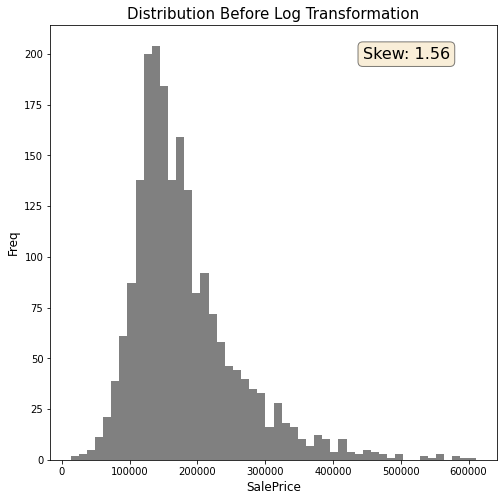

In [67]:
# log(target) distribution
plt.figure(figsize = (8,8))
plt.title("Distribution Before Log Transformation", size = 15)
plt.hist(df_train_2['SalePrice'], bins = 50, color = 'gray')
plt.xlabel('SalePrice', size = 12)
plt.ylabel('Freq', size = 12)

# text
text = f"Skew: {round(df_train_2['SalePrice'].skew(), 2)}"
plt.text(0.70, 0.95, text, transform=plt.gca().transAxes, fontsize=16,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5));

# save fig
plt.savefig('./project2_graphs/saleprice_before_log.jpeg')

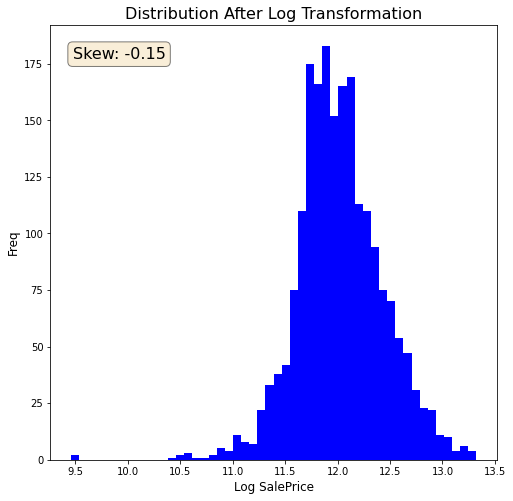

In [68]:
# log(target) distribution
plt.figure(figsize = (8,8))
plt.title("Distribution After Log Transformation", size = 16)
plt.hist(np.log(df_train_2['SalePrice']), bins = 50, color = 'blue')
plt.xlabel('Log SalePrice', size = 12)
plt.ylabel('Freq', size = 12);

# text
text2 = f"Skew: {round(np.log(df_train_2['SalePrice']).skew(), 2)}"
plt.text(0.05, 0.95, text2, transform=plt.gca().transAxes, fontsize=16,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5));

# save fig
plt.savefig('./project2_graphs/saleprice_after_log.jpeg')

The log transformation substantially improves the 'normality' of our target variable!

In [69]:
model2_lr_log = LinearRegression()
model2_lr_log.fit(Z_set1_train, np.log(y_set1_train))

LinearRegression()

In [70]:
model2_lr_log.score(Z_set1_train, np.log(y_set1_train))

0.8368755909510686

In [71]:
model2_lr_log.score(Z_set1_test, np.log(y_set1_test))

0.8349555586269002

In [72]:
y_log_preds_model2 = model2_lr_log.predict(Z_set1_test)

In [73]:
# NOTE: remember, for the actual 'SalePrice' predictions, must use np.exp() to convert the prediction back into 'SalePrice' regular magnitude/unit
mean_squared_error(y_set1_test, np.exp(y_log_preds_model2), squared = False)

25911.354524009304

In [74]:
# store scores for this model
model2_log_scores = {"Name": "MLR Log Transform", "Training" : round(model2_lr_log.score(Z_set1_train, np.log(y_set1_train)), 4),
                    "Test" : round(model2_lr_log.score(Z_set1_test, np.log(y_set1_test)), 4),
                    "RMSE": round(mean_squared_error(y_set1_test, np.exp(y_log_preds_model2), squared = False), 2)}

The log transformation on our 'SalePrice' target does a MUCH better job at tightening up our predictions and reducing RMSE. This holds good merit for purposes of prediction.

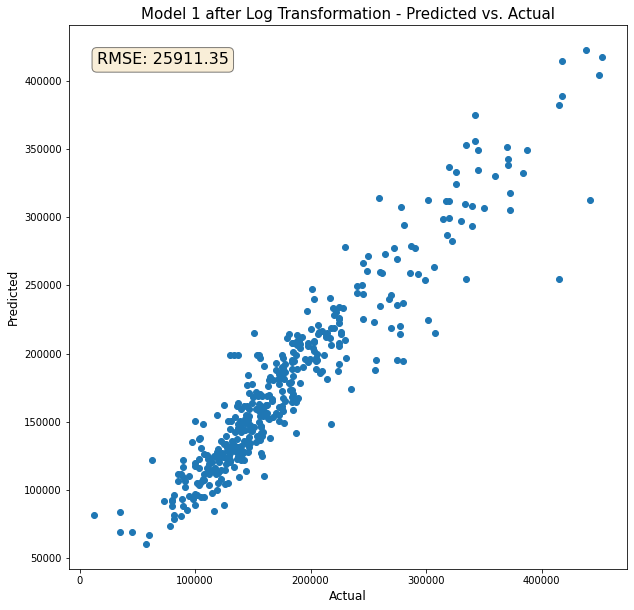

In [75]:
# Plotting Model 1 after Log Transformation - Pred vs. Actual
plt.figure(figsize = (10,10))
plt.scatter(x = y_set1_test, y = np.exp(y_log_preds_model2))
plt.title("Model 1 after Log Transformation - Predicted vs. Actual", size = 15)
plt.xlabel("Actual", size = 12)
plt.ylabel("Predicted", size = 12)

text5 = f"RMSE: {round(mean_squared_error(y_set1_test, np.exp(y_log_preds_model2), squared = False), 2)}"
plt.text(0.05, 0.95, text5, transform=plt.gca().transAxes, fontsize=16,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5));

# save figure
plt.savefig('./project2_graphs/model1_log_pred_vs_actual.jpeg')

In [76]:
# saving & submitting results of this model
test3_sc = sc.transform(df_test_2[features_1])
sub_model1_log = pd.DataFrame(np.exp(model2_lr_log.predict(test3_sc)), columns = ['SalePrice'], index = testcsv['Id'])
sub_model1_log.to_csv('./project2_output/sub_model1_log.csv')

---
#### Model 2 - RidgeCV

For Model 2, I'll use the same feature set as before, but this time we will perform l2 regularization using Ridge. Since I want to know what is the best alpha to use, I will pass a list of alphas for Ridge to try. <br> 
Since we've discovered that log transforming our target variable improves our RMSE, and therefore our predictive power, let's apply the same strategy to both Ridge and Lasso.

In [77]:
# let's make a ton of alphas to check
alphas = np.logspace(0, 5, 100)

# Instantiate model --> Cross-validate over our list of ridge alphas.
ridge_cv = RidgeCV(alphas = alphas, cv = 5)

# Fit model using best ridge alpha! --> remember, always fit model on training
ridge_cv.fit(Z_set1_train, np.log(y_set1_train))

RidgeCV(alphas=array([1.00000000e+00, 1.12332403e+00, 1.26185688e+00, 1.41747416e+00,
       1.59228279e+00, 1.78864953e+00, 2.00923300e+00, 2.25701972e+00,
       2.53536449e+00, 2.84803587e+00, 3.19926714e+00, 3.59381366e+00,
       4.03701726e+00, 4.53487851e+00, 5.09413801e+00, 5.72236766e+00,
       6.42807312e+00, 7.22080902e+00, 8.11130831e+00, 9.11162756e+00,
       1.02353102e+01, 1.14975700e+0...
       6.89261210e+03, 7.74263683e+03, 8.69749003e+03, 9.77009957e+03,
       1.09749877e+04, 1.23284674e+04, 1.38488637e+04, 1.55567614e+04,
       1.74752840e+04, 1.96304065e+04, 2.20513074e+04, 2.47707636e+04,
       2.78255940e+04, 3.12571585e+04, 3.51119173e+04, 3.94420606e+04,
       4.43062146e+04, 4.97702356e+04, 5.59081018e+04, 6.28029144e+04,
       7.05480231e+04, 7.92482898e+04, 8.90215085e+04, 1.00000000e+05]),
        cv=5)

In [78]:
# optimal alpha value
ridge_cv.alpha_

93.26033468832199

In [79]:
# best score from ridge CV
ridge_cv.best_score_

0.8179382987738938

In [80]:
# Train vs. Test Score
print(f"Ridge, Training Score: {round(ridge_cv.score(Z_set1_train, np.log(y_set1_train)), 4)}")
print(f"Ridge, Test Score: {round(ridge_cv.score(Z_set1_test, np.log(y_set1_test)), 4)}")

Ridge, Training Score: 0.8357
Ridge, Test Score: 0.8298


In [81]:
# ridge predictions!
y_set1_ridge_preds = ridge_cv.predict(Z_set1_test)

In [82]:
# RMSE
round(mean_squared_error(y_set1_test, np.exp(y_set1_ridge_preds), squared = False), 2)

# RMSE is slightly worse than our MLR Log model

26559.09

In [83]:
# storing the scores for Ridge
ridge_cv_scores = {"Name": "Ridge","Training": round(ridge_cv.score(Z_set1_train, np.log(y_set1_train)), 4),
                   "Test": round(ridge_cv.score(Z_set1_test, np.log(y_set1_test)), 4),
                   "RMSE": round(mean_squared_error(y_set1_test, np.exp(y_set1_ridge_preds), squared = False), 2)} 

In [84]:
# Ridge Prediction on Real Test set

test2_sc = sc.transform(df_test_2[features_1])
sub_ridgecv_log = pd.DataFrame(np.exp(ridge_cv.predict(test2_sc)), columns = ['SalePrice'], index = testcsv['Id']) # 'Id' column from OG test.csv
sub_ridgecv_log.to_csv('./project2_output/sub_ridgecv_log.csv')

---
#### Model 3 - LassoCV

This time, I'll use Lasso to figure out which features in my current feature set could be zeroed out. I'll use the remaining as "feature_1b", or feature set 1b.

In [85]:
# Like Ridge, set up a list of Lasso alphas to check
l_alphas = np.logspace(-3, 0, 5)

# Cross-validate over our list of Lasso alphas.
lasso_cv = LassoCV(alphas = l_alphas, cv = 5)

# Fits model using best ridge alpha!
lasso_cv.fit(Z_set1_train, np.log(y_set1_train))

LassoCV(alphas=array([0.001     , 0.00562341, 0.03162278, 0.17782794, 1.        ]),
        cv=5)

In [86]:
lasso_cv.alpha_

0.001

In [87]:
print("Training:",round(lasso_cv.score(Z_set1_train, np.log(y_set1_train)), 4))
print("Test:", round(lasso_cv.score(Z_set1_test, np.log(y_set1_test)), 4))

Training: 0.8365
Test: 0.8348


In [88]:
# LassoCV predictions
y_set1_lasso_preds = lasso_cv.predict(Z_set1_test)

In [89]:
# RMSE
round(mean_squared_error(y_set1_test, np.exp(y_set1_lasso_preds), squared = False), 2)

# RMSE is better than Ridge model, but just slightly worse than our MLR

26063.2

In [90]:
# storing the scores for Lasso
lasso_cv_scores = {"Name": "Lasso 1","Training": round(lasso_cv.score(Z_set1_train, np.log(y_set1_train)), 4),
                   "Test": round(lasso_cv.score(Z_set1_test, np.log(y_set1_test)), 4),
                   "RMSE": round(mean_squared_error(y_set1_test, np.exp(y_set1_lasso_preds), squared = False), 2)} 

In [91]:
# Ridge Prediction on Real Test set

test4_sc = sc.transform(df_test_2[features_1])
sub_lassocv_log = pd.DataFrame(np.exp(lasso_cv.predict(test4_sc)), columns = ['SalePrice'], index = testcsv['Id']) # 'Id' column from OG test.csv
sub_lassocv_log.to_csv('./project2_output/sub_lassocv_log.csv')

Lasso's current performance is nearly comparable to that of my original MLR model using the first feature set. <br>
Let's shift attention to the coefficients Lasso zeroes out. The goal is to keep any that have NOT been completely reduced.

In [92]:
# investigating Lasso coefs
lasso_coefs = lasso_cv.coef_

pd.Series(lasso_coefs)

# LASSO can aid in feature selection, select the features that LASSO did not zero out coefs
lasso_coefs = pd.Series(lasso_coefs, features_1)

# save this as a DataFrame
lasso_coefs = pd.DataFrame(lasso_coefs.sort_values(ascending = False), columns = ['Coeff'])

In [93]:
# Now, let's make feature set 2 selecting only the variables that Lasso did NOT zero out
features_2 = list(lasso_coefs[lasso_coefs['Coeff'] != 0].index)

print(f"Our features were reduced by 6. From {len(features_1)} to {len(features_2)}")

Our features were reduced by 6. From 34 to 28


---
### Feature Set 2

Since the last set showed that MLR and Lasso performed better, let's continue with both of those but on a slightly more select set of features --> features_2.

#### MLR (w/ log transformation & filtered features)

In [94]:
# new X & y for 2nd round of performance testing
X_set2 = df_train_2[features_2]
y_set2 = df_train_2['SalePrice']

In [95]:
# new train/test splits
X_set2_train, X_set2_test, y_set2_train, y_set2_test = train_test_split(X_set2, y_set2, test_size = 0.2, random_state = 42) # random_state for replicability

In [96]:
# new scaling
sc = StandardScaler()

# fit_transform the X_set1_train
Z_set2_train = sc.fit_transform(X_set2_train)

# just transform X_set1_test
Z_set2_test = sc.transform(X_set2_test)

In [97]:
# instantiate model
model3 = LinearRegression()
model3.fit(Z_set2_train, np.log(y_set2_train))

LinearRegression()

In [98]:
# model evaluation
print(model3.score(Z_set2_train, np.log(y_set2_train)), model3.score(Z_set2_test, np.log(y_set2_test)))

# predictions
y_model3_preds = model3.predict(Z_set2_test)

# RMSE
mean_squared_error(y_set2_test, np.exp(y_model3_preds), squared = False)

0.8368698319298807 0.8348768658539463


25896.95535867405

This model is promising! The RMSE is slightly more improved than our original MLR model (log transformed) using the original feature set.

In [99]:
# store scores for this model
model3_scores = {"Name": "MLR Log Model 2","Training" : round(model3.score(Z_set2_train, np.log(y_set2_train)), 4),
                    "Test" : round(model3.score(Z_set2_test, np.log(y_set2_test)), 4),
                    "RMSE": round(mean_squared_error(y_set2_test, np.exp(y_model3_preds), squared = False), 2)}

In [100]:
# saving & submitting results of this model
test4_sc = sc.transform(df_test_2[features_2])
sub_model3 = pd.DataFrame(np.exp(model3.predict(test4_sc)), columns = ['SalePrice'], index = testcsv['Id'])
sub_model3.to_csv('./project2_output/sub_model3.csv')

---
#### Lasso (using feature set 2)

In [101]:
# Like Ridge, set up a list of Lasso alphas to check
l_alphas = np.logspace(-3, 0, 5)

# Cross-validate over our list of Lasso alphas.
lasso_cv = LassoCV(alphas = l_alphas, cv = 5)

# Fits model using best ridge alpha!
lasso_cv.fit(Z_set2_train, np.log(y_set2_train))

LassoCV(alphas=array([0.001     , 0.00562341, 0.03162278, 0.17782794, 1.        ]),
        cv=5)

In [102]:
lasso_cv.alpha_

0.001

In [103]:
print("Training:",round(lasso_cv.score(Z_set2_train, np.log(y_set2_train)), 4))
print("Test:", round(lasso_cv.score(Z_set2_test, np.log(y_set2_test)), 4))

Training: 0.8365
Test: 0.8348


In [104]:
# LassoCV predictions
y_set2_lasso_preds = lasso_cv.predict(Z_set2_test)

# RMSE
round(mean_squared_error(y_set2_test, np.exp(y_set2_lasso_preds), squared = False), 2)

26062.27

In [105]:
# storing the scores for Lasso
lasso_cv_scores2 = {"Name": "Lasso 2","Training": round(lasso_cv.score(Z_set2_train, np.log(y_set2_train)), 4),
                   "Test": round(lasso_cv.score(Z_set2_test, np.log(y_set2_test)), 4),
                   "RMSE": round(mean_squared_error(y_set2_test, np.exp(y_set2_lasso_preds), squared = False), 2)} 

Looks like this Lasso's prediction is not as strong as the MLR either, so perhaps what needs to change completely to further improve the RMSE is the feature set itself.

---

### Final Model - Trimming Outliers

In [106]:
# of the features, maybe 1 or more are extreme outliers?
features_2

['Overall Qual',
 'Gr Liv Area',
 'Garage Cars',
 '1st Flr SF',
 'Foundation_CBlock',
 'Foundation_PConc',
 'Total Bsmt SF',
 'garage_age',
 'Garage Area',
 'TotRms AbvGrd',
 'Foundation_Wood',
 'Foundation_Stone',
 'Foundation_PConc',
 'Kitchen Qual_TA',
 'Garage Finish_RFn',
 'Exter Qual_Gd',
 'Bsmt Qual_Po',
 'Foundation_Slab',
 'Bsmt Qual_Fa',
 'Bsmt Qual_Gd',
 'Kitchen Qual_Fa',
 'Garage Finish_Unf',
 'Exter Qual_Fa',
 'Kitchen Qual_Gd',
 'Bsmt Qual_TA',
 'age',
 'remodel_age',
 'Kitchen Qual_TA']

In [107]:
features_2_skew = [df_train_2[feat].skew() for feat in features_2]

In [108]:
features_2_skew = pd.DataFrame(data = features_2_skew, index = features_2, columns = ['Skew'])

In [109]:
# these are the MOST skewed variables in feature set 2
features_2_skew[features_2_skew['Skew'] > 1]

# of these, 'Gr Liv Area' had the strongest correlation w/ 'SalePrice'

,Skew
Gr Liv Area,1.281492
1st Flr SF,1.635146
Total Bsmt SF,1.389436
Foundation_Wood,31.999977
Foundation_Stone,20.194030
Bsmt Qual_Po,45.287967
Foundation_Slab,7.577887
Bsmt Qual_Fa,5.590991
Kitchen Qual_Fa,6.381325
Exter Qual_Fa,8.718292


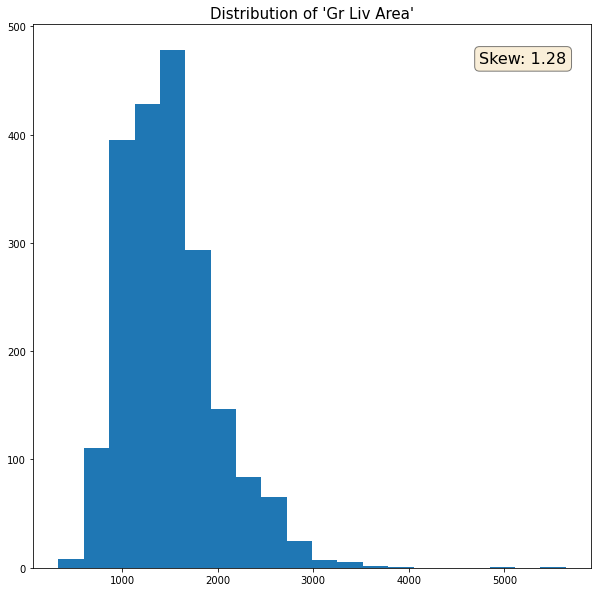

In [110]:
plt.figure(figsize = (10,10))
plt.title("Distribution of 'Gr Liv Area'", size = 15)
plt.hist(df_train_2['Gr Liv Area'], bins = 20)

# text
text3 = f"Skew: 1.28"
plt.text(0.80, 0.95, text3, transform=plt.gca().transAxes, fontsize=16,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5));

# savefig
plt.savefig('./project2_graphs/livingarea_dist.jpeg')

In [111]:
df_train_2['Gr Liv Area'].sort_values(ascending = False)

960     5642.0
1885    5095.0
616     3820.0
1897    3672.0
1035    3608.0
         ...  
1292     498.0
1643     492.0
1518     480.0
432      438.0
1428     334.0
Name: Gr Liv Area, Length: 2051, dtype: float64

--- 
After some EDA investigation into 'Gr Liv Area', I noticed that it is likely strongly correlated with 2 other highly skewed variables ('1st Flr SF' and 'Total Bsmt SF'). The alrgest values have similar IDs which suggests that the homes that are outliers are the same. <br> 

Since the distibution shows a strong right skew, I will trim the largest outliers of the feature matrix & target series that I will train the model on. <br>

I will only trim the train set, and leave the test set as is.

In [112]:
# tri anything ABOVE roughly a little more than 3 standard deviations of area within the mean (aka top ~ 0.1%)
trim = np.percentile(df_train_2['Gr Liv Area'], 99.9)

In [113]:
# make new df, df_train_3
df_train_3 = df_train_2[df_train_2['Gr Liv Area'] <= trim]

In [114]:
# make new X & y from df_train_3

# X
X_df3 = df_train_3[features_2]

# y
y_df3 = df_train_3['SalePrice']

In [115]:
# train/test/split
X_df3_train, X_df3_test, y_df3_train, y_df3_test = train_test_split(X_df3, y_df3, test_size = 0.2, random_state = 42)

In [116]:
# Scale Data
sc = StandardScaler()

# fit_transform train X
Z_df3_train = sc.fit_transform(X_df3_train)

# transform test X
Z_df3_test = sc.transform(X_df3_test)

In [117]:
# instantiate MLR model and fit on X & y using log transform on y_df3_train
model4 = LinearRegression()

# fitting
model4.fit(Z_df3_train, np.log(y_df3_train))

LinearRegression()

In [118]:
# model evaluation
print(model4.score(Z_df3_train, np.log(y_df3_train)))

# predictions
y_model4_preds = model4.predict(Z_df3_test)

# RMSE
print(mean_squared_error(y_df3_test, np.exp(y_model4_preds), squared = False))

# store scores
model4_scores = {"Name": "MLR Log Model 3", "Training" : round(model4.score(Z_df3_train, np.log(y_df3_train)), 4),
                 "Test": None,
                "RMSE" : round(mean_squared_error(y_df3_test, np.exp(y_model4_preds), squared = False), 2)}

0.8632512501746049
24586.61822575757


This is the best model yet. The train score is high and the RMSE has been further minimized.

In [119]:
# saving & submitting results of this model
test5_sc = sc.transform(df_test_2[features_2])

sub_model5 = pd.DataFrame(np.exp(model4.predict(test5_sc)), columns = ['SalePrice'], index = testcsv['Id'])

sub_model5.to_csv('./project2_output/sub_model5.csv')

---
### Part VI: Conclusion

I determined that the MLR model (model 4) using log transformation performed the best after trimming outliers. The model has a promising training r2 score and it minimized RMSE to a greater extent than its predecessors. To conclude, I will create a short DataFrame to show the performance of each model.

In [120]:
score_r2 = []
score_rmse = []
score_value = []
model_name = []
model = [model1_lr_scores, model2_log_scores, ridge_cv_scores, lasso_cv_scores, model3_scores, lasso_cv_scores2, model4_scores]

for m in model:
    model_name.append(list(m.values())[0])
    score_r2.append(list(m.items())[1][1])
    score_rmse.append(list(m.items())[3][1])
    score_value.append(list(m.items())[1][1])

In [121]:
model_scores = pd.DataFrame({"Training r2":score_r2, "RMSE" : score_rmse}, index = model_name).sort_values(by = 'RMSE', ascending = True)

model_scores

,Training r2,RMSE
MLR Log Model 3,0.8633,24586.62
MLR Log Model 2,0.8369,25896.96
MLR Log Transform,0.8369,25911.35
Lasso 2,0.8365,26062.27
Lasso 1,0.8365,26063.20
Ridge,0.8357,26559.09
MLR Model 1,0.8270,27374.59
